In [1]:
import numpy as np
import pandas as pd
import pymc3 as pm
from pyei.r_by_c import RowByColumnEI
from pyei.data import Datasets
from pyei.plot_utils import plot_precinct_scatterplot

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


In [2]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

In [3]:
%load_ext autoreload
%autoreload 2

# Demo of RxC models and plotting using Santa Clara data

We show examples of using and examining models available in pyei using a sample data set:

In [4]:
data = Datasets.Santa_Clara.to_dataframe()
precinct_pops = np.array(data['total2'])
votes_fractions = np.array(data[['pct_for_hardy2', 'pct_for_kolstad2', 'pct_for_nadeem2']]).T
candidate_names = ["Hardy", "Kolstad", "Nadeem"]
group_fractions = np.array(data[['pct_ind_vote', 'pct_e_asian_vote', 'pct_non_asian_vote']]).T
demographic_group_names = ["ind", "e_asian", "non_asian"]

In [5]:
ei = RowByColumnEI(model_name='multinomial-dirichlet')

In [6]:
ei.fit(group_fractions, votes_fractions, precinct_pops, demographic_group_names, candidate_names)

r = 3 rows (demographic groups)
c = 3 columns (candidates or voting outcomes)
number of precincts = 42


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, conc_params]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 106 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


We can also pass to the fit() function additional keyword arguments for the sampler, such as:

- draws - the number of samples to draw
- chains - the number of chains
- tune - number of iteration to tune
- cores - number of chains to run in parallel

(see https://docs.pymc.io/api/inference.html sampling.sample for more)

## Plotting

Here is some of the plotting functionality for the r x c case. For more, see intro_notebooks/Plotting_with_PyEI.ipynb

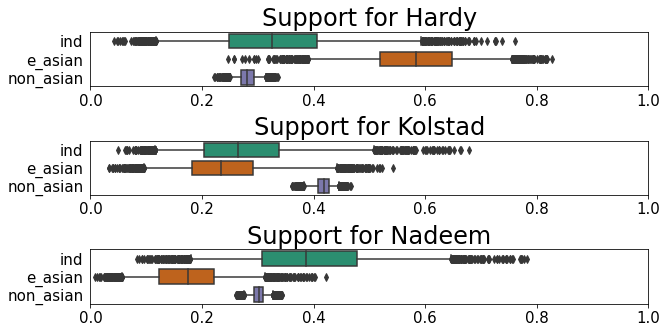

In [7]:
ax = ei.plot_boxplots()

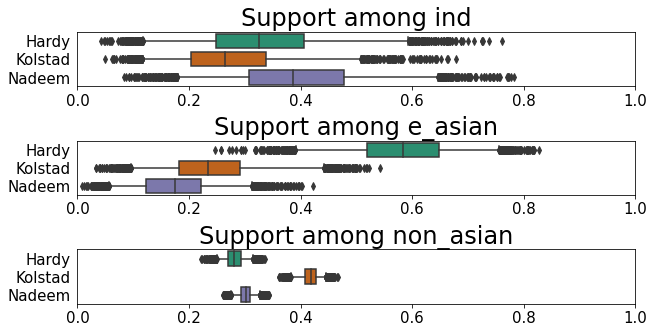

In [8]:
ax = ei.plot_boxplots(plot_by="group")

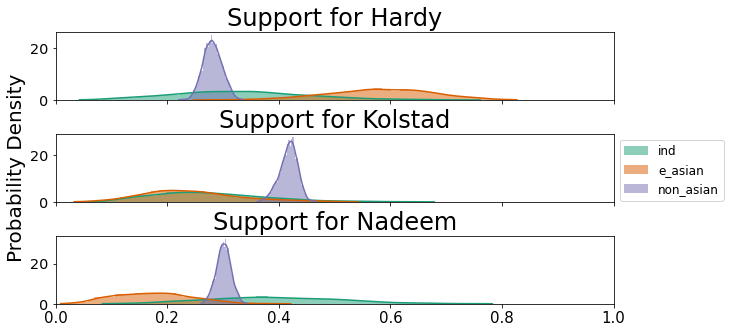

In [9]:
ax = ei.plot_kdes(plot_by="candidate")

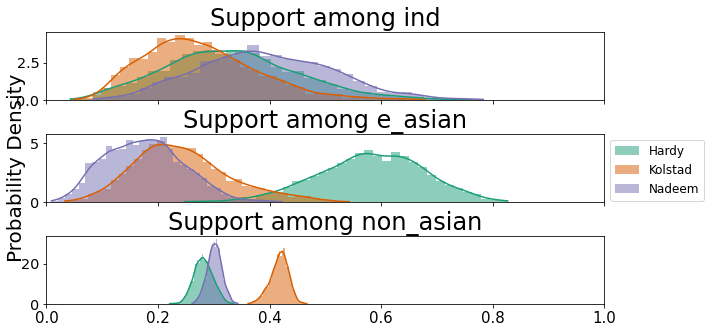

In [10]:
ax = ei.plot_kdes(plot_by="group")

<AxesSubplot:title={'center':'e_asian'}, xlabel='Support for Kolstad'>

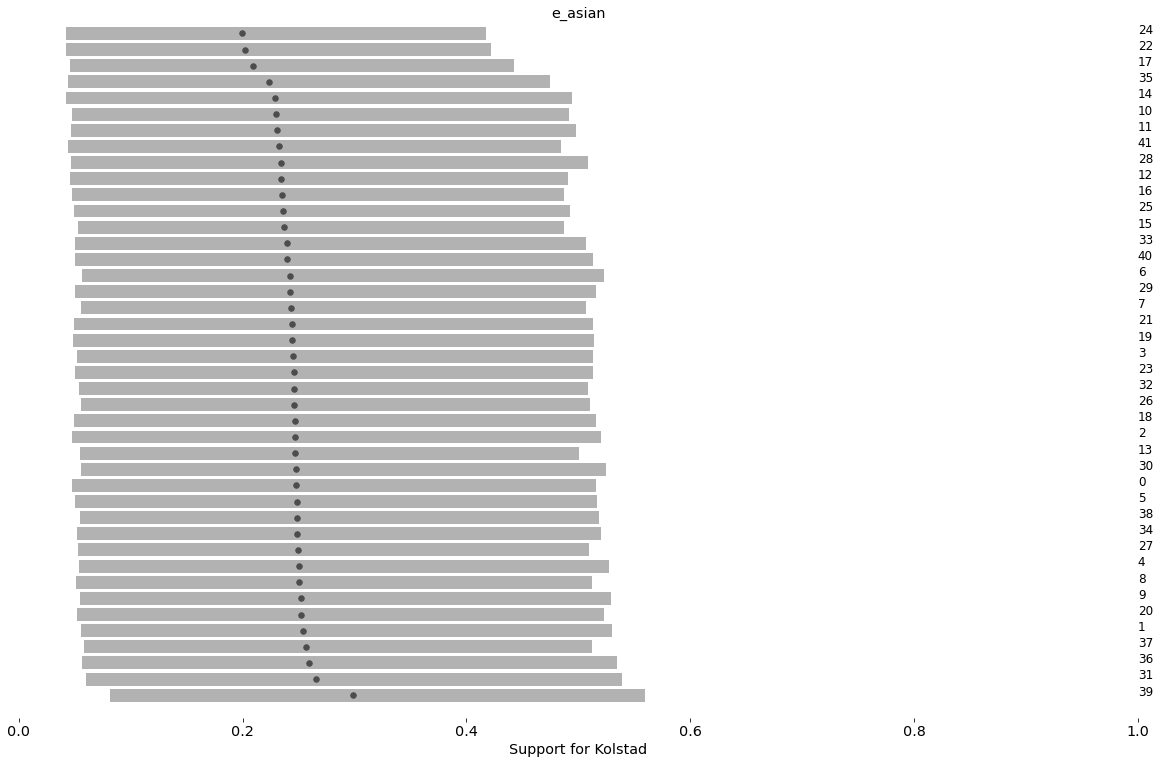

In [11]:
ei.plot_intervals_by_precinct('e_asian', 'Kolstad') # 95% credible intervals by precinct

## Polarization
There are several options for calculating and reporting on polarization that are supported.

### a) Calculate probability that difference in voting preferences between two groups  is above a given threshold

In [12]:
ei.polarization_report(["ind", "e_asian"], "Nadeem", threshold=.50)

There is a 2.8% probability that the difference between the groups' preferences for Nadeem (ind - e_asian)  is more than 0.50.


2.8

In [13]:
ei.polarization_report(["ind", "e_asian"], "Nadeem", threshold=.50, verbose=False)

2.8

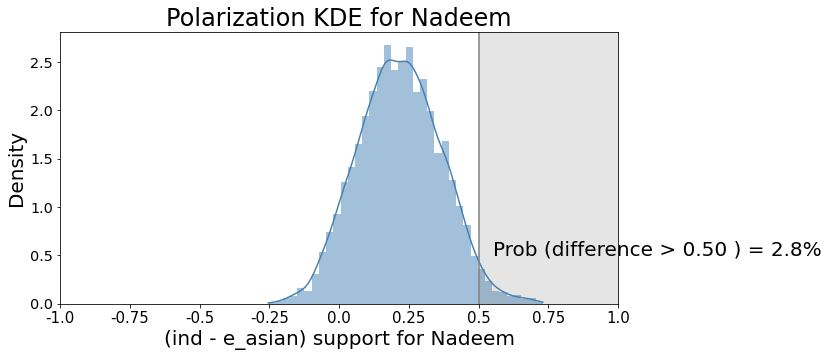

In [14]:
ax = ei.plot_polarization_kde(["ind", "e_asian"], "Nadeem", threshold=0.50, show_threshold=True)

### b) Find central credible interval (with specified probability level) for the difference in voting preferences between two groups

In [15]:
ei.polarization_report(["ind", "e_asian"], "Nadeem", percentile=95)

There is a 95% probability that the difference between the groups' preferences for Nadeem (ind - e_asian) is between [-0.07, 0.51].


(-0.06533964743143864, 0.5083089509158765)

In [16]:
ei.polarization_report(["ind", "e_asian"], "Nadeem", percentile=95, verbose=False)

(-0.06533964743143864, 0.5083089509158765)

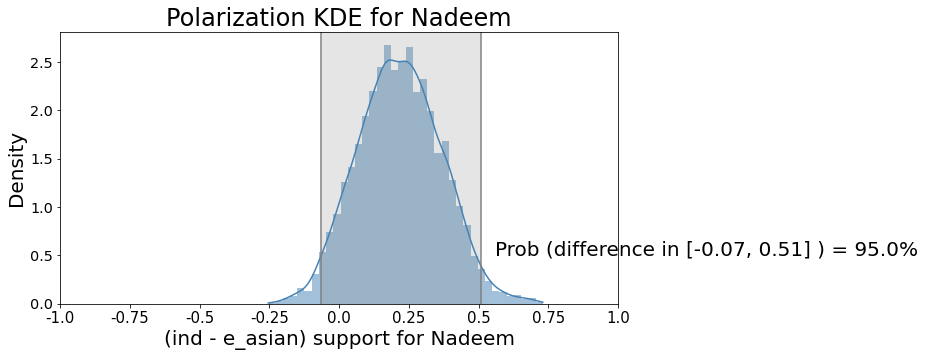

In [17]:
ax = ei.plot_polarization_kde(["ind", "e_asian"], "Nadeem", percentile=95, show_threshold=True)

## Win margins among a demographic group
Suppose we want to understand how a candidate's margin of victory among one demographic group compared to their margin overall. While we can use our input data to determine the Candidate A - Candidate B margin polity-wide, there are several ways to inspect the EI output to determine that margin among a given demographic group. The below functions return credible intervals for the preference margin — (E. Asian preference for Hardy - E. Asian preference for Nadeem). Multiplying these preferences by the total E. Asian population will return estimated the estimated vote counts margin.

In [18]:
ei.margin_report("e_asian", ["Hardy", "Nadeem"], percentile=95, verbose=True)

There is a 95% probability that the difference between the e_asians' preferences for Hardy and Nadeem is between [0.12, 0.67].


(0.11942473102478394, 0.6669003105082515)

In [19]:
ei.margin_report("e_asian", ["Hardy", "Nadeem"], percentile=95, verbose=False)

(0.11942473102478394, 0.6669003105082515)

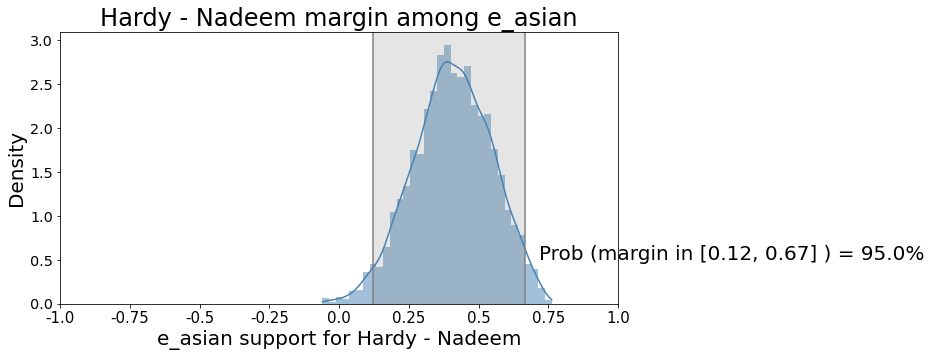

In [20]:
ei.plot_margin_kde("e_asian", ["Hardy", "Nadeem"], percentile=95, show_threshold=True)

In [39]:
ei.margin_report("e_asian", ["Hardy", "Nadeem"], threshold=0.2, verbose=True)

There is a 92.2% probability that the difference between e_asians' preferences for Hardy and Nadeem is more than 0.20.


92.225

In [40]:
ei.margin_report("e_asian", ["Hardy", "Nadeem"], threshold=0.2, verbose=False)

92.225

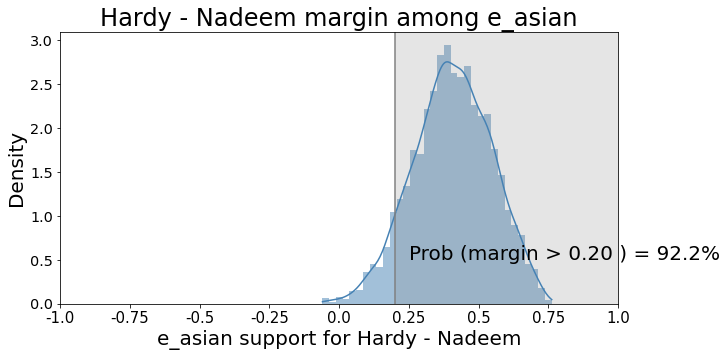

In [41]:
ei.plot_margin_kde("e_asian", ["Hardy", "Nadeem"], threshold=0.2, show_threshold=True)

### c) polarization of preferred candidates

In [21]:
ei.candidate_of_choice_polarization_report()

In 68.975 percent of samples, the district-level candidates of choice for e_asian and ind voters differ.
In 84.1 percent of samples, the district-level candidates of choice for non_asian and ind voters differ.
In 96.225 percent of samples, the district-level candidates of choice for non_asian and e_asian voters differ.


{('e_asian', 'ind'): 0.68975,
 ('ind', 'e_asian'): 0.68975,
 ('non_asian', 'ind'): 0.841,
 ('ind', 'non_asian'): 0.841,
 ('non_asian', 'e_asian'): 0.96225,
 ('e_asian', 'non_asian'): 0.96225}

In [22]:
differ_dict = ei.candidate_of_choice_polarization_report(verbose = False)
print(differ_dict[('ind','e_asian')])
print(differ_dict[('e_asian','ind')])

0.68975
0.68975


## Plotting across EI runs
Let's see how different `multinomial-dirichlet-modified` is from `multinomial-dirichlet`

In [23]:
ei_modified = RowByColumnEI(model_name='multinomial-dirichlet-modified', pareto_shape=100, pareto_scale=100)

In [24]:
ei_modified.fit(group_fractions, votes_fractions, precinct_pops, demographic_group_names, candidate_names, tune=2000)

r = 3 rows (demographic groups)
c = 3 columns (candidates or voting outcomes)
number of precincts = 42


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, phi, kappa]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 197 seconds.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.


In [25]:
ei_runs = [ei_modified, ei]
run_names = ['multinomial-dirichlet-modified', 'multinomial-dirichlet']

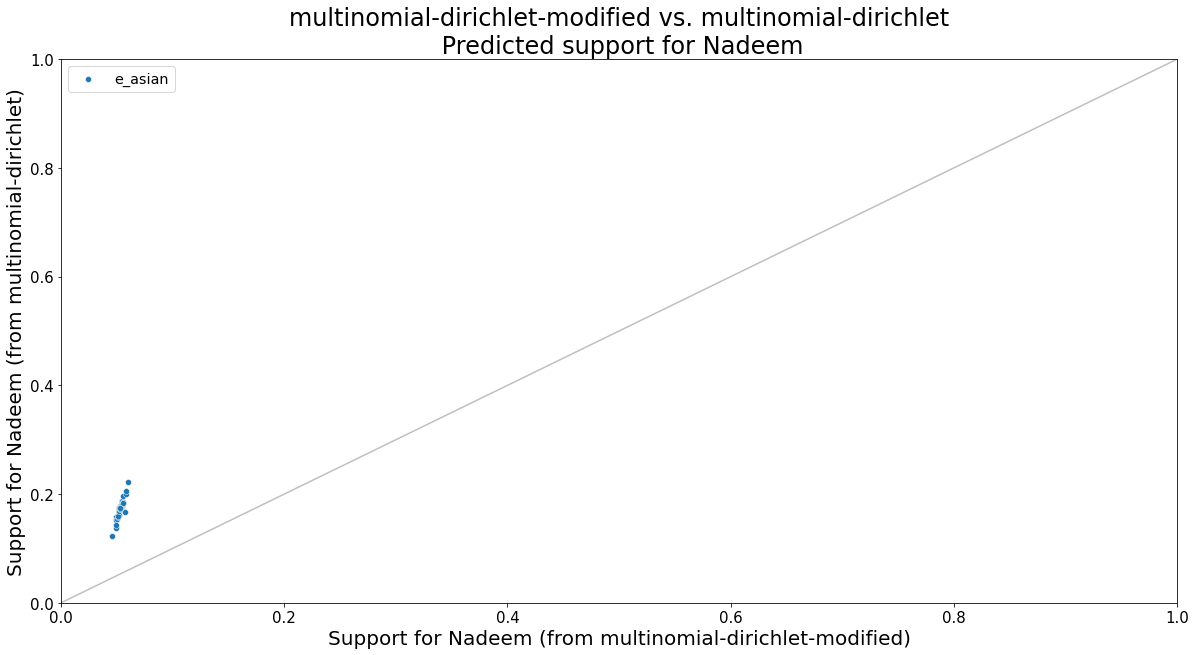

In [26]:
ax = plot_precinct_scatterplot(ei_runs, run_names, "Nadeem", "e_asian")

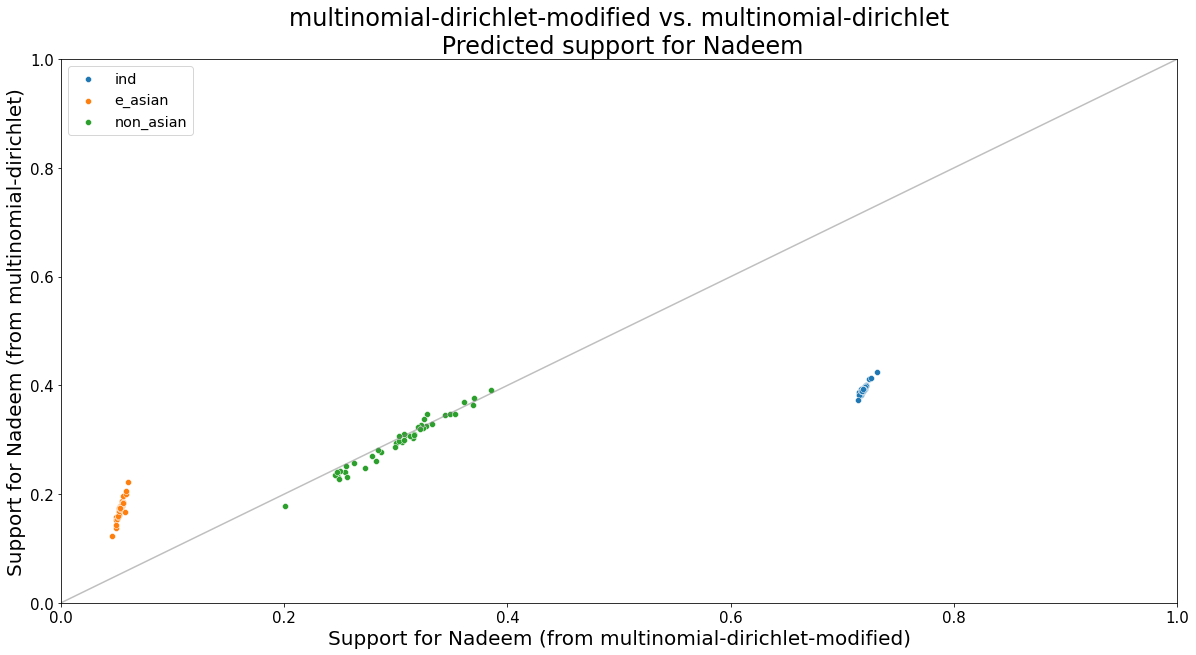

In [27]:
ax = plot_precinct_scatterplot(ei_runs, run_names, "Nadeem")

This tells us that the `multinomial-dirichlet` version seemed to overestimate Nadeem's support among East Asians and underestimate Nadeem's support among Indians, relative to the `multinomial-dirichlet-modified` version.

## Summaries

RowByColumnEI objects have methods for text summaries and summary statistics.

In [28]:
print(ei.summary())


            Computed from the raw b_ samples by multiplying by population and then 
            getting the proportion of the total pop 
            (total pop=summed across all districts):
            The posterior mean for the district-level voting preference of
                ind for Hardy is
                0.331
                95% equal-tailed credible interval:  [0.11762035 0.5916334 ]
                The posterior mean for the district-level voting preference of
                ind for Kolstad is
                0.276
                95% equal-tailed credible interval:  [0.1165565  0.50761907]
                The posterior mean for the district-level voting preference of
                ind for Nadeem is
                0.393
                95% equal-tailed credible interval:  [0.1794994  0.64617975]
                The posterior mean for the district-level voting preference of
                e_asian for Hardy is
                0.582
                95% equal-tailed credib

In [29]:
ei.candidate_of_choice_report()

ind
     - In 32.65 percent of samples, the district-level vote preference of 
       ind for Hardy was higher than for any other candidate.
     - In 15.9 percent of samples, the district-level vote preference of 
       ind for Kolstad was higher than for any other candidate.
     - In 51.45 percent of samples, the district-level vote preference of 
       ind for Nadeem was higher than for any other candidate.
e_asian
     - In 96.075 percent of samples, the district-level vote preference of 
       e_asian for Hardy was higher than for any other candidate.
     - In 3.775 percent of samples, the district-level vote preference of 
       e_asian for Kolstad was higher than for any other candidate.
     - In 0.15 percent of samples, the district-level vote preference of 
       e_asian for Nadeem was higher than for any other candidate.
non_asian
     - In 0.0 percent of samples, the district-level vote preference of 
       non_asian for Hardy was higher than for any other candidate

{('ind', 'Hardy'): 0.3265,
 ('ind', 'Kolstad'): 0.159,
 ('ind', 'Nadeem'): 0.5145,
 ('e_asian', 'Hardy'): 0.96075,
 ('e_asian', 'Kolstad'): 0.03775,
 ('e_asian', 'Nadeem'): 0.0015,
 ('non_asian', 'Hardy'): 0.0,
 ('non_asian', 'Kolstad'): 1.0,
 ('non_asian', 'Nadeem'): 0.0}

In [30]:
ei.candidate_of_choice_report(verbose = False)

{('ind', 'Hardy'): 0.3265,
 ('ind', 'Kolstad'): 0.159,
 ('ind', 'Nadeem'): 0.5145,
 ('e_asian', 'Hardy'): 0.96075,
 ('e_asian', 'Kolstad'): 0.03775,
 ('e_asian', 'Nadeem'): 0.0015,
 ('non_asian', 'Hardy'): 0.0,
 ('non_asian', 'Kolstad'): 1.0,
 ('non_asian', 'Nadeem'): 0.0}

### Posterior means of voting preference for each group/candidate:

In [31]:
posterior_mean_voting_prefs = ei.posterior_mean_voting_prefs
df = pd.DataFrame(posterior_mean_voting_prefs, columns=candidate_names, index=demographic_group_names)
df.head()

,Hardy,Kolstad,Nadeem
ind,0.331344,0.275822,0.392834
e_asian,0.581568,0.242850,0.175583
non_asian,0.281457,0.417281,0.301262


### 95% equal-tailed credible intervals for voting preferences for each group:

In [32]:
num_groups, num_candidates = ei.num_groups_and_num_candidates # R, C
credible_interval_95_mean_voting_prefs = ei.credible_interval_95_mean_voting_prefs
for r in range(num_groups):
    for c in range(num_candidates):
        print(demographic_group_names[r],candidate_names[c], credible_interval_95_mean_voting_prefs[r][c])

ind Hardy [0.11762035 0.5916334 ]
ind Kolstad [0.1165565  0.50761907]
ind Nadeem [0.1794994  0.64617975]
e_asian Hardy [0.39080712 0.75521395]
e_asian Kolstad [0.09627479 0.44142198]
e_asian Nadeem [0.05654427 0.31199335]
non_asian Hardy [0.249466   0.31498204]
non_asian Kolstad [0.38197423 0.44541234]
non_asian Nadeem [0.27477617 0.32704327]


### Precinct-level means and credible intervals:

In [33]:
precinct_posterior_means, precinct_credible_intervals = ei.precinct_level_estimates()
# Note: precinct_posterior_means has shape num_precincts x r x c
# Note: precinct_credible_intervals has shape num_precincts x r x c x 2 
r = 0
c = 0
print(f'Precinct support for {candidate_names[c]} among {demographic_group_names[r]}')
print(precinct_posterior_means[:,r,c])
print(f'95% credible intervals of precinct support for {candidate_names[c]} among {demographic_group_names[r]}')
print(precinct_credible_intervals[:,r,c])

Precinct support for Hardy among ind
[0.33261636 0.33282614 0.32300274 0.3269045  0.32677213 0.3279406
 0.3295946  0.33196948 0.32877926 0.33120869 0.33768396 0.33591052
 0.3418888  0.33055503 0.33248635 0.31942232 0.33774071 0.33575207
 0.33169113 0.33960472 0.33303164 0.33510135 0.32386467 0.33727398
 0.34424421 0.33340176 0.33015357 0.34094361 0.33150084 0.33247001
 0.33000358 0.32434998 0.32831057 0.33118542 0.32985268 0.34042233
 0.32944044 0.30981424 0.3313001  0.32895447 0.33505762 0.33232518]
95% credible intervals of precinct support for Hardy among ind
[[0.07220259 0.65521737]
 [0.07660899 0.6520554 ]
 [0.07086434 0.63469553]
 [0.06811218 0.6466837 ]
 [0.07096265 0.66099774]
 [0.07402257 0.65217521]
 [0.07198686 0.65101806]
 [0.07698424 0.65733508]
 [0.07037748 0.66357537]
 [0.07902397 0.66039601]
 [0.07263607 0.66205677]
 [0.07290618 0.65601524]
 [0.07880562 0.67078409]
 [0.07274348 0.6534104 ]
 [0.07544112 0.64834351]
 [0.07190657 0.63211871]
 [0.08459088 0.6677263 ]
 [0.07

## Samples

Samples from the posterior are accessible. 

Precinct level samples are aggregated into district level preference samples by weighting each precinct by its population:

In [34]:
ei.sampled_voting_prefs.shape # ei.sampled_voting_prefs is samples of district-level voter preference: num_samples x r x c

(4000, 3, 3)

Samples can also be obtained directly by the parameter name in the model:

In [35]:
ei.sim_trace["b"].shape # ei.sim_trace["b"] is samples of precinct-level voter preference: num_samples x num_precincts x r x c

(4000, 42, 3, 3)

Samples of hyperparameters are available:

In [36]:
ei_modified.sim_trace["kappa"].mean(axis=0)

array([101.00122081, 101.017909  , 101.03562328])

### Accessing (and visualizing) the pymc model

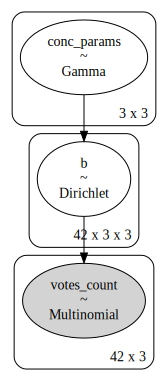

In [37]:
model = ei.sim_model
pm.model_to_graphviz(model)